In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.linear_model import LinearRegression

In [16]:
ameriflux = pd.read_csv('freq_anual/AMF_PE-QFR_FLUXNET_FULLSET_YY_2018-2019_3-5.csv',na_values=-9999) # Dados da AMERIFLUX
modis = pd.read_csv('freq_anual/Npp_500m.csv',header=None)
modis.loc[modis[2].isin(['A2018001','A2019001'])] # Dados MODIS para o ano de 2018 e 2019

,0,1,2,3,4,5,6,7,8,9,...,284,285,286,287,288,289,290,291,292,293
17,MOD17A3HGF.A2018001.h10v09.006.2021364004127.N...,MOD17A3HGF,A2018001,Lat-3.834436Lon-73.31897Samp17Line17,2021364004127,12176.0,11588.0,32762.0,6622.0,6391.0,...,12052.0,11984.0,11975.0,12014.0,12411.0,12431.0,12027.0,12061.0,11647.0,11426.0
18,MOD17A3HGF.A2019001.h10v09.006.2021001044819.N...,MOD17A3HGF,A2019001,Lat-3.834436Lon-73.31897Samp17Line17,2021001044819,10845.0,10508.0,32762.0,5106.0,5571.0,...,10485.0,10111.0,10692.0,10243.0,10199.0,10259.0,9908.0,10596.0,11172.0,10997.0


In [11]:
npp = (ameriflux['NEE_VUT_MEAN'] + ameriflux['RECO_DT_VUT_MEAN']) / 1000 # NPP do Ameriflux gerado pela média do RECO (DURANTE O DIA) + NEE e convertido de gC m−2 y−1 para kgC/m²/year divindo o valor por 1000
npp # NPP calculado                                               # OBS1: RECO_DT = Partitioning NEE using the daytime flux method, Lasslop et al. (2010)
                                                                  # OBS2: _VUT_ = Variable USTAR threshold for each year
                                                                  # OBS3: _MEAN = Average NEE after filtering using multiple USTAR thresholds;

0    2.526743
1    2.518219
dtype: float64

In [12]:
def convert_unit(x):
    return x/10000



modis_data = modis.loc[modis[2].isin(['A2018001','A2019001'])].copy() # Dados de NPP nos anos de 2018 e 2019


modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas


modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 


modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe


modis_data.apply(convert_unit) # Conversão para kgC/m²/year como está disposto no mapa (Adição de um 0 a mais para coincidir com o mapa do site)
# OBS: Os dados de NPP foram retirados de uma área de extensão de 8.5km[17 pixels] x 8.5km[17 pixels],
#      o que equivale a 289 (17x17) dados de NPP na área

,1,2,3,4,5,6,7,8,9,10,...,280,281,282,283,284,285,286,287,288,289
0,,,,,,,,,,,,,,,,,,,,,
A2018001,1.2176,1.1588,3.2762,0.6622,0.6391,0.6549,0.6469,3.2762,3.2762,3.2762,...,1.2052,1.1984,1.1975,1.2014,1.2411,1.2431,1.2027,1.2061,1.1647,1.1426
A2019001,1.0845,1.0508,3.2762,0.5106,0.5571,0.5418,0.5875,3.2762,3.2762,3.2762,...,1.0485,1.0111,1.0692,1.0243,1.0199,1.0259,0.9908,1.0596,1.1172,1.0997


In [13]:
modis_npp_mean = modis_data.apply(lambda x:x/10000).mean(axis=1) # Média de NPP nesses anos
modis_npp_mean

0
A2018001    1.172167
A2019001    1.078046
dtype: float64

In [14]:
modis_npp_mean_values = modis_npp_mean.values # valores do npp do modis
ameriflux_npp_values = npp.values #valores do npp do ameriflux

npp_dataframe = {
    'modis_NPP':modis_npp_mean_values,
    'ameriflux_NPP':ameriflux_npp_values
}

npp_dataframe = pd.DataFrame(npp_dataframe) # dataframe com os valores do npp
npp_dataframe

,modis_NPP,ameriflux_NPP
0,1.172167,2.526743
1,1.078046,2.518219


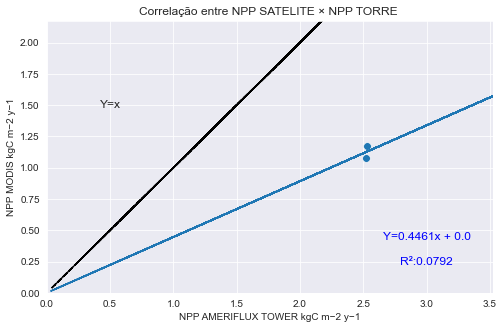

In [127]:
sns.set_style('darkgrid')
f, ax = plt.subplots(1,figsize=(8, 5))

sns.scatterplot(x='ameriflux_NPP', y='modis_NPP', data=npp_dataframe, s=60) # Valores de npp no grafico


rng = np.random.default_rng(1234) #seed para valores aleatórios


lr_fi_false = LinearRegression(fit_intercept=False) #Fazer o valor de b em y=ax+b ser igual a 0


fitted_reg = lr_fi_false.fit(npp_dataframe[['ameriflux_NPP']],npp_dataframe[['modis_NPP']])


x = rng.uniform(0, 10, size=100) # gerando 100 valores aleatórios 
y = x * fitted_reg.coef_ # y=ax


r2_score = fitted_reg.score(npp_dataframe[['ameriflux_NPP']],npp_dataframe[['modis_NPP']]) # R² Score

#Textos das retas
plt.text(3, 0.45, f'Y={round(fitted_reg.coef_[0][0],4)}x + {fitted_reg.intercept_}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
plt.text(3, 0.25, f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue')


plt.text(0.5, 1.5, f'Y=x',fontsize=12, ha='center', va='center') # Texto da reta Preta

ax.plot(x,y[0]) #reta de regressão
ax.plot(x,x, 'k--') # reta y=x

ax.set_ylim((0, npp_dataframe['modis_NPP'].max() + 1)) # tamanho limite do plot no eixo y
ax.set_xlim((0, npp_dataframe['ameriflux_NPP'].max() + 1)) # tamanho limite do plot no eixo y

plt.title("Correlação entre NPP SATELITE × NPP TORRE ")

plt.xlabel("NPP AMERIFLUX TOWER kgC m−2 y−1")
plt.ylabel("NPP MODIS kgC m−2 y−1")

plt.show()

In [ ]:
#==============================================================================================================#


In [159]:
ameriflux_mensal = pd.read_csv('freq_mensal/AMF_PE-QFR_FLUXNET_FULLSET_MM_2018-2019_3-5.csv',na_values=-9999)

ameriflux_mensal['NPP'] = (ameriflux_mensal['NEE_VUT_MEAN'] + ameriflux_mensal['RECO_DT_VUT_MEAN'])
#OBS: NPP = gC m−2  d−1

In [160]:
ameriflux_mensal.head()

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_VUT_05,GPP_DT_VUT_16,GPP_DT_VUT_25,GPP_DT_VUT_50,GPP_DT_VUT_75,GPP_DT_VUT_84,GPP_DT_VUT_95,RECO_SR,RECO_SR_N,NPP
0,201801,25.385,1.000000,23.952,1.123,1.000000,26.631,2.268,1.000000,25.411,...,10.34810,11.05710,11.26340,12.22880,12.47240,12.98260,13.08750,NaN,NaN,4.68190
1,201802,26.631,1.000000,25.103,1.337,1.000000,28.036,2.344,1.000000,26.439,...,8.61924,9.36547,9.47711,10.65170,11.73890,11.80820,11.96250,NaN,NaN,6.93569
2,201803,25.988,1.000000,24.464,1.121,1.000000,27.410,2.363,1.000000,26.084,...,11.20550,11.36420,11.56210,11.91730,11.99570,12.07780,12.28930,NaN,NaN,6.09266
3,201804,25.478,0.715278,24.284,0.919,0.730435,26.577,2.171,0.701333,25.275,...,7.41977,7.97334,8.24826,8.60903,9.31576,9.46066,9.58334,NaN,NaN,4.54051
4,201805,25.353,1.000000,24.294,0.815,1.000000,26.327,1.879,1.000000,25.421,...,5.16431,7.15643,8.14249,8.54827,8.79999,8.95125,9.26907,NaN,NaN,5.71601


Text(0, 0.5, 'NPP')

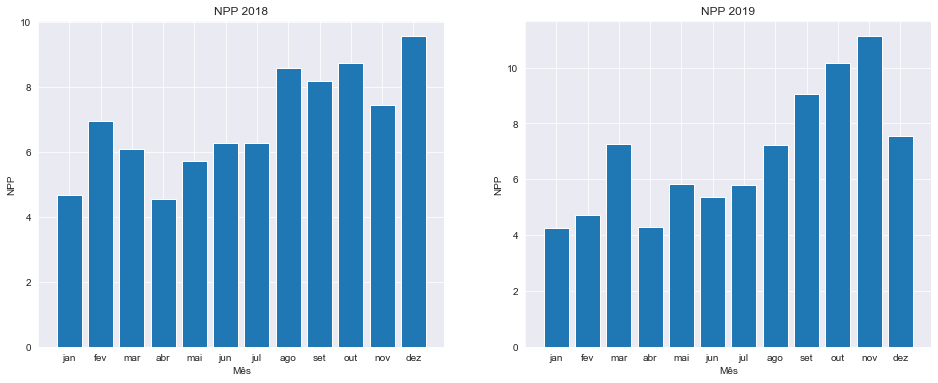

In [235]:
# NPP mensal


npp = ameriflux_mensal['NPP'] # NPP CALCULADO
meses_abreviados = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]

df = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[0:12]}) # 2018
df2 = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[12:]}) # 2019


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(df["Meses"], df["NPP"])
axs[0].set_title("NPP 2018")
axs[0].set_xlabel("Mês")
axs[0].set_ylabel("NPP")


axs[1].bar(df2["Meses"], df2["NPP"])
axs[1].set_title("NPP 2019")
axs[1].set_xlabel("Mês")
axs[1].set_ylabel("NPP")

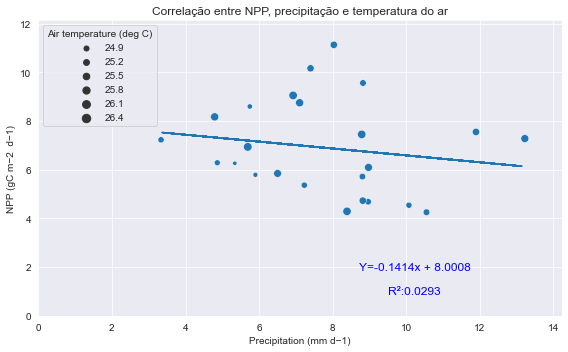

In [217]:
f, ax = plt.subplots(1,figsize=(8, 5))


eixo_x = ameriflux_mensal['P_ERA'] #Data filled by using ERA5 downscaling
tamanho = ameriflux_mensal['TA_ERA'] #Air temperature (deg C) Data filled by using ERA5 downscaling


sns.scatterplot(x=eixo_x, y=npp, data=ameriflux_mensal,size=tamanho) # Valores de npp no grafico

rng = np.random.default_rng(1234) #seed para valores aleatórios

lr_fi_false = LinearRegression() #Fazer o valor de b em y=ax+b ser igual a 0

fitted_reg = lr_fi_false.fit(ameriflux_mensal[['P_ERA']],ameriflux_mensal[['NPP']])


x = rng.uniform(eixo_x.min(), eixo_x.max(), size=100) # gerando 100 valores aleatórios 
y = x * fitted_reg.coef_ + fitted_reg.intercept_[0] # y=ax


r2_score = fitted_reg.score(ameriflux_mensal[['P_ERA']],ameriflux_mensal[['NPP']]) # R² Score


text_coord_x = eixo_x.max() - 3 #Coordenada do texto no eixo x


#Textos das retas
plt.text(text_coord_x, 2, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
plt.text(text_coord_x, 1, f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²


ax.plot(x,y[0]) #reta de regressão

ax.set_ylim((0, (ameriflux_mensal['NPP'].max() + 1))) # tamanho limite do plot no eixo y
ax.set_xlim((0, ameriflux_mensal['P_ERA'].max() + 1)) # tamanho limite do plot no eixo y

plt.title("Correlação entre NPP, precipitação e temperatura do ar")

plt.legend(title="Air temperature (deg C)",loc='upper left')

plt.xlabel('Precipitation (mm d−1)')
plt.ylabel("NPP (gC m−2  d−1)")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'NPP (gC m−2  d−1)')

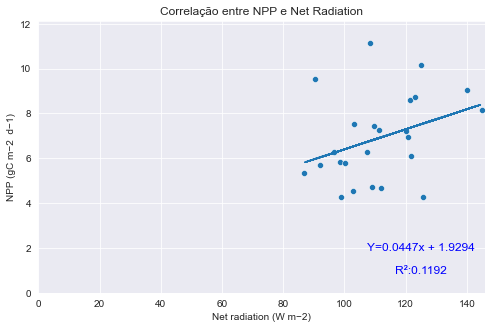

In [247]:
f, ax = plt.subplots(1,figsize=(8, 5))

net_radiation = ameriflux_mensal['NETRAD']

sns.scatterplot(x=net_radiation,y=npp, data=ameriflux_mensal)


rng = np.random.default_rng(1234) #seed para valores aleatórios

lr_fi_false = LinearRegression() #Fazer o valor de b em y=ax+b ser igual a 0

fitted_reg = lr_fi_false.fit(ameriflux_mensal[['NETRAD']],ameriflux_mensal[['NPP']])


x = rng.uniform(net_radiation.min(), net_radiation.max(), size=100) # gerando 100 valores aleatórios 
y = x * fitted_reg.coef_ + fitted_reg.intercept_[0] # y=ax


r2_score = fitted_reg.score(ameriflux_mensal[['NETRAD']],ameriflux_mensal[['NPP']]) # R² Score


text_coord_x = net_radiation.max() - 20 #Coordenada do texto no eixo x


#Textos das retas
plt.text(text_coord_x, 2, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
plt.text(text_coord_x, 1, f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²


ax.plot(x,y[0]) #reta de regressão

ax.set_ylim((0, (npp.max() + 1))) # tamanho limite do plot no eixo y
ax.set_xlim((0, net_radiation.max() + 1)) # tamanho limite do plot no eixo y

plt.title('Correlação entre NPP e Net Radiation')
plt.xlabel('Net radiation (W m−2)')
plt.ylabel("NPP (gC m−2  d−1)")

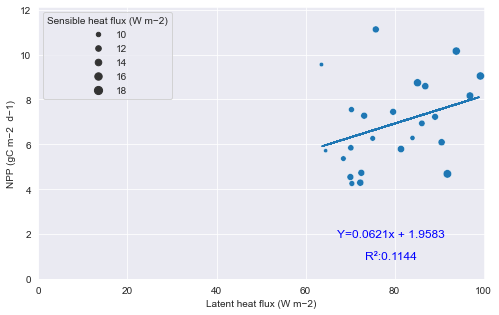

In [249]:
f, ax = plt.subplots(1,figsize=(8, 5))

latent_heat = ameriflux_mensal['LE_F_MDS']
sensible_heat = ameriflux_mensal['H_F_MDS']

sns.scatterplot(x=latent_heat,y=npp, data=ameriflux_mensal, size=sensible_heat)


rng = np.random.default_rng(1234) #seed para valores aleatórios

lr_fi_false = LinearRegression() #Fazer o valor de b em y=ax+b ser igual a 0

fitted_reg = lr_fi_false.fit(ameriflux_mensal[['LE_F_MDS']],ameriflux_mensal[['NPP']])


x = rng.uniform(Latent_heat.min(), Latent_heat.max(), size=100) # gerando 100 valores aleatórios 
y = x * fitted_reg.coef_ + fitted_reg.intercept_[0] # y=ax


r2_score = fitted_reg.score(ameriflux_mensal[['LE_F_MDS']],ameriflux_mensal[['NPP']]) # R² Score


text_coord_x = latent_heat.max() - 20 #Coordenada do texto no eixo x


#Textos das retas
plt.text(text_coord_x, 2, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
plt.text(text_coord_x, 1, f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²


ax.plot(x,y[0]) #reta de regressão

ax.set_ylim((0, (npp.max() + 1))) # tamanho limite do plot no eixo y
ax.set_xlim((0, latent_heat.max() + 1)) # tamanho limite do plot no eixo y

plt.xlabel('Latent heat flux (W m−2)')
plt.ylabel("NPP (gC m−2  d−1)")

plt.legend(title="Sensible heat flux (W m−2)",loc='upper left')
